# This Notebook looks at the relationship between ILO and ASPIRE data:
- Plot the ILO total social protection (w/o healthcare spendings) and ASPIRE social_p and social_r (Adrien's calculations) in a scatterplot
- Carry out a regression analyses with both piecewise linear and linear functions
- Interpolate the countries missing in ASPIRE to ILO

## Load functions

In [112]:
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

In [113]:
# WB country name translation
any_name_to_wb_name = pd.read_csv("../git/country_names/out/any_name_to_wb_name.csv",index_col="any",
                                  squeeze=True, encoding="utf-8")

In [114]:
# WB api wrapper
import sys
sys.path.insert(0, '../git/wb_api_wrapper')
from wb_api_wrapper import mrv

In [115]:
# Import plotting routines
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

## Open the ILO data

In [116]:
ILO_data = pd.read_csv('ILO/ILO.csv', index_col=0, encoding='utf-8', na_values=['...', '…'])
ILO_data.index=(ILO_data.index.str.strip()) # Deletes white spaces at the end of the index entries in the ILO index
ILO_data.sort_index().head(12) # Correct flaws in the ILO data
ILO_data = ILO_data.rename(index=any_name_to_wb_name) # rename the index using a dictionary-like translation, which in this case is any_name_to_wb_name

In [117]:
ILO_data.ix['Fiji']

Total public social protection expenditure and health expenditure         NaN
Public health care                                                       1.87
Public social protection                                                  NaN
year                                                                      NaN
sanity                                                               #VALEUR!
Name: Fiji, dtype: object

In [118]:
ILO_data.rename(columns = {'Total public social protection expenditure and health expenditure':
                           'Total public social protection expenditure and health expenditure (% GDP)'},
               inplace=True)
ILO_data.rename(columns = {'Public health care':
                           'Public health care (% GDP)'},
               inplace=True)
ILO_data.rename(columns = {'Public social protection':
                           'Public social protection (% GDP)'},
               inplace=True)
ILO_data = ILO_data.rename(index=any_name_to_wb_name)
ILO_data.sort_index(inplace=True)
ILO_data.head(4)

,Total public social protection expenditure and health expenditure (% GDP),Public health care (% GDP),Public social protection (% GDP),year,sanity
country,,,,,
Afghanistan,5.60,3.61,1.99,2011.0,0
Albania,10.83,2.68,8.15,2011.0,0
Algeria,8.53,3.17,5.36,2011.0,0
Angola,6.79,2.15,4.64,2011.0,0


### Remove some non-country data entries

In [119]:
ILO_data.drop('Europe', inplace=True, errors='ignore')
ILO_data.drop('Latin America and the Caribbean', inplace=True, errors='ignore')
ILO_data.drop('Asia and the Middle East', inplace=True, errors='ignore')

## Get social_p and social_r

In [120]:
df_socprot = pd.read_csv('../git/resilience_indicator/df.csv', index_col='country',
                         usecols=['country','social_p', 'social_r'])
df_socprot = df_socprot.rename(index=any_name_to_wb_name)

In [121]:
df_socprot.head(2)

,social_p,social_r
country,,
Albania,0.262950,0.179360
Argentina,0.200153,0.142648


## Plot the data

### Prepare the data sets for plotting

In [122]:
ilo_plot1 = ILO_data['Public social protection (% GDP)']
ilo_plot1 = pd.to_numeric(ilo_plot1, errors='coerce') # This changes str to flt

Bring both datasets into the same array to make a scatterplot

In [123]:
df_plot = pd.concat([ilo_plot1, df_socprot['social_p'], df_socprot['social_r']], axis=1)

In [124]:
x_grid = np.linspace(0,df_plot['Public social protection (% GDP)'].max(),100)

### Scatterplot

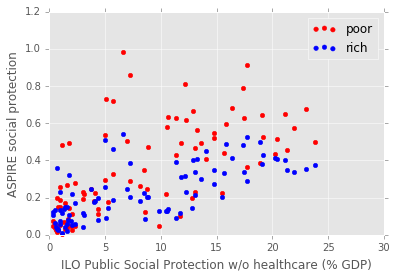

In [125]:
fig1 = plt.figure()
plt.scatter(df_plot['Public social protection (% GDP)'], df_plot['social_p'], color='r', label='poor', clip_on=False)
plt.scatter(df_plot['Public social protection (% GDP)'], df_plot['social_r'], color='b', label='rich', clip_on=False)

#for k in df_plot.index:
    #plt.annotate(xy = [df_plot.loc[k,'Public social protection (% GDP)'], df_plot.loc[k,'social_p']], s=k, xycoords='data')
    #plt.annotate(xy = [df_plot.loc[k,'Public social protection (% GDP)'], df_plot.loc[k,'social_r']], s=k, xycoords='data')

plt.xlabel('ILO Public Social Protection w/o healthcare (% GDP)')
plt.ylabel('ASPIRE social protection')
plt.xlim(0)
plt.ylim(0)
plt.legend()

# Regression analysis

In [126]:
XY = df_plot.dropna() # Get rid of NaNs
X = XY['Public social protection (% GDP)'].values
Yp = XY['social_p'].values
Yr = XY['social_r'].values

## Linear Regression

In [127]:
regress_linear_p = sm.OLS(Yp, X, missing='drop').fit() # This is for a simple linear model OLS fit
regress_linear_p.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     264.3
Date:                Tue, 19 Apr 2016   Prob (F-statistic):           3.05e-28
Time:                        17:45:01   Log-Likelihood:                 11.757
No. Observations:                  89   AIC:                            -21.51
Df Residuals:                      88   BIC:                            -19.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0339      0.002     16.256      0.000         0.030     0.038
==============================================================================
Omnibus:                       12.328   Durbin-Watson:                   2.305
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.062
Skew:                           0.739   Prob(JB):                     0.000884
Kurtosis:                       4.268   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [128]:
regress_linear_r = sm.OLS(Yr, X, missing='drop').fit() # This is for a simple linear model OLS fit
regress_linear_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     327.1
Date:                Tue, 19 Apr 2016   Prob (F-statistic):           2.19e-31
Time:                        17:45:01   Log-Likelihood:                 59.805
No. Observations:                  89   AIC:                            -117.6
Df Residuals:                      88   BIC:                            -115.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0220      0.001     18.085      0.000         0.020     0.024
==============================================================================
Omnibus:                       12.591   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.002
Skew:                           0.776   Prob(JB):                     0.000911
Kurtosis:                       4.168   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
print(regress_linear_p.params)
print(regress_linear_r.params)

[ 0.03389196]
[ 0.0219745]


In [130]:
y_hat_lin_p = x_grid * regress_linear_p.params
y_hat_lin_r = x_grid * regress_linear_r.params

## Piecewise linear regression

In [131]:
def piecewise_linear(x, Theta, a, b):
    y = np.piecewise(x, [x <= Theta, x > Theta ], [lambda x:a*x, lambda x:a*x + b*(x-Theta)])
    y[np.isnan(x)]=np.nan
    return y

In [132]:
popt_p, pcov_lin_p = sp.optimize.curve_fit(piecewise_linear, np.array(X), np.array(Yp)) # input needs np.array
popt_r, pcov_lin_r = sp.optimize.curve_fit(piecewise_linear, np.array(X), np.array(Yr)) # input needs np.array

In [133]:
print(popt_p)
print(popt_r)

[ 5.7500001   0.07375213 -0.06517851]
[ 0.65734648  0.1768411  -0.16247625]


In [134]:
y_hat_plin_p = piecewise_linear(x_grid, popt_p[0], popt_p[1], popt_p[2])
y_hat_plin_r = piecewise_linear(x_grid, popt_r[0], popt_r[1], popt_r[2])

### Statistics for piecewise

In [135]:
#type(XY)

In [136]:
#res = ols(formula='XY ~ ', data=).fit()

## Non-parametric fit

In [137]:
import pyqt_fit.nonparam_regression as smooth
from pyqt_fit import npr_methods

In [138]:
k0_p = smooth.NonParamRegression(X, Yp, method=npr_methods.LocalPolynomialKernel(q=1))
k0_p.fit()
k0_r = smooth.NonParamRegression(X, Yr, method=npr_methods.LocalPolynomialKernel(q=1))
k0_r.fit()

# Interpolate data for "missing countries"

In [139]:
country_diff = ILO_data.index.difference(df_socprot.index)
df_socprot_missing = pd.DataFrame(ILO_data.loc[country_diff], index=country_diff)

# With the cont linear function:
df_socprot_missing['social_p cont. lin. est. from ILO'] = df_socprot_missing['Public social protection (% GDP)'].values * regress_linear_p.params
df_socprot_missing['social_r cont. lin. est. from ILO'] = df_socprot_missing['Public social protection (% GDP)'].values * regress_linear_r.params

# With the piecewise function:
df_socprot_missing['social_p piecewise lin. est. from ILO'] = piecewise_linear(df_socprot_missing['Public social protection (% GDP)'].values, popt_p[0], popt_p[1], popt_p[2])
df_socprot_missing['social_r piecewise lin. est. from ILO'] = piecewise_linear(df_socprot_missing['Public social protection (% GDP)'].values, popt_r[0], popt_r[1], popt_r[2])

# Drop columns which are non social_p or social_r
df_socprot_missing.drop(['Total public social protection expenditure and health expenditure (% GDP)'], axis=1, inplace=True)
df_socprot_missing.drop(['Public health care (% GDP)'], axis=1, inplace=True)
df_socprot_missing.drop(['Public social protection (% GDP)'], axis=1, inplace=True)
df_socprot_missing.drop(['year'], axis=1, inplace=True)
df_socprot_missing.drop(['sanity'], axis=1, inplace=True)

social_p cont. lin. est. from ILO       NaN
social_r cont. lin. est. from ILO       NaN
social_p piecewise lin. est. from ILO   NaN
social_r piecewise lin. est. from ILO   NaN
Name: Fiji, dtype: float64

In [141]:
df_socprot_missing.head(5)

,social_p cont. lin. est. from ILO,social_r cont. lin. est. from ILO,social_p piecewise lin. est. from ILO,social_r piecewise lin. est. from ILO
country,,,,
Afghanistan,0.067445,0.043729,0.146767,0.135389
Algeria,0.181661,0.117783,0.395311,0.183799
Angola,0.157259,0.101962,0.342210,0.173456
Antigua and Barbuda,0.103370,0.067022,0.224944,0.150616
Aruba,0.277914,0.180191,0.445080,0.224595


Save the output

In [142]:
df_socprot_missing.to_csv('output/missing_countries_estimation.csv', encoding = 'utf-8')

In [143]:
df_socprot_new = df_socprot.append(df_socprot_missing)
df_socprot_new.head(2)

,social_p,social_p cont. lin. est. from ILO,social_p piecewise lin. est. from ILO,social_r,social_r cont. lin. est. from ILO,social_r piecewise lin. est. from ILO
country,,,,,,
Albania,0.262950,NaN,NaN,0.179360,NaN,NaN
Argentina,0.200153,NaN,NaN,0.142648,NaN,NaN


In [144]:
df_socprot_new.to_csv('output/all_countries_estimation.csv', encoding = 'utf-8')

## Plot the regression

In [145]:
# For labelling:
mylist_p  =['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia and the Middle East', 'Australia', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados',
       'Belarus', 'Belgium', 'Belize', 'Bhutan', 'Bolivia', 'Brazil', 'Brunei Darussalam','Bulgaria', 'Burundi',
       'Cameroon', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Cuba', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica',
       'Ecuador', 'Egypt, Arab Rep.', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia',
       'Fiji', 'Finland', 'France', 'Gabon', 'Gambia, The', 'Georgia',
       'Ghana', 'Grenada', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras',
       'Hong Kong SAR, China', 'Hungary', 'Iceland', 'India', 'Indonesia',
       'Iran, Islamic Rep.', 'Iraq', 'Ireland', 'Israel', 'Italy','Japan', 'Jordan', 'Kazakhstan', 'Kiribati',
       'Korea, Rep.', 'Kosovo', 'Kuwait', 'Lebanon', 'Lesotho',
       'Liberia', 'Libya', 'Lithuania', 'Luxembourg', 'Macao SAR, China',
       'Macedonia, FYR', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Mauritania', 'Mauritius',
       'Mexico', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru',
       'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Nigeria', 'North America',
       'Norway', 'Oceania', 'Oman', 'Palau', 'Panama','Papua New Guinea', 'Peru', 'Philippines', 'Poland',
       'Portugal', 'Qatar', 'Romania', 'Russian Federation', 'Samoa', 'San Marino', 'Saudi Arabia', 'Serbia',
       'Seychelles', 'Singapore', 'Solomon Islands', 'South Africa', 'Spain', 'Sri Lanka',
       'Sudan', 'Swaziland', 'Sweden', 'Switzerland', 'São Tomé and Príncipe',
       'Taiwan', 'Tajikistan', 'Timor-Leste', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey',
       'Tuvalu', 'Uganda', 'United Arab Emirates', 'United Kingdom', 'United States', 'Uzbekistan',
       'Vanuatu', 'Venezuela, RB', 'Vietnam', 'Zimbabwe']

In [146]:
# For labelling
mylist_r  =['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia and the Middle East', 'Australia', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados',
       'Belarus', 'Belgium', 'Belize', 'Bhutan', 'Bolivia', 'Brazil', 'Brunei Darussalam','Bulgaria', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Cook Islands', 'Costa Rica', "Cote d'Ivoire", 'Cuba', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti',
       'Dominica', 'Ecuador', 'Egypt, Arab Rep.', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia',
       'Fiji', 'Finland', 'France', 'Gabon', 'Gambia, The', 'Georgia',
       'Ghana', 'Grenada', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras',
       'Hong Kong SAR, China', 'Hungary', 'Iceland', 'India', 'Indonesia',
       'Iran, Islamic Rep.', 'Iraq', 'Ireland', 'Israel', 'Italy','Japan', 'Jordan', 'Kazakhstan', 'Kiribati',
       'Korea, Rep.', 'Kosovo', 'Kuwait', 'Kyrgyz Republic', 'Lebanon', 'Lesotho',
       'Liberia', 'Libya', 'Lithuania', 'Luxembourg', 'Macao SAR, China',
       'Macedonia, FYR', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Mauritania', 'Mauritius',
       'Mexico', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru',
       'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Nigeria', 'North America',
       'Norway', 'Oceania', 'Oman', 'Palau', 'Panama','Papua New Guinea', 'Peru', 'Philippines', 'Poland',
       'Portugal', 'Qatar', 'Romania', 'Russian Federation', 'Samoa', 'San Marino', 'Saudi Arabia', 'Serbia',
       'Seychelles', 'Singapore', 'Solomon Islands', 'South Africa', 'Spain', 'Sri Lanka',
       'Sudan', 'Swaziland', 'Sweden', 'Switzerland', 'São Tomé and Príncipe',
       'Taiwan', 'Tajikistan', 'Thailand', 'Timor-Leste', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey',
       'Tuvalu', 'Uganda', 'United Arab Emirates', 'United Kingdom', 'United States', 'Uzbekistan',
       'Vanuatu', 'Venezuela, RB', 'Vietnam', 'Zimbabwe']

In [147]:
df_socprot_missing['social_p cont. lin. est. from ILO']

country
Afghanistan                       0.067445
Algeria                           0.181661
Angola                            0.157259
Antigua and Barbuda               0.103370
Aruba                             0.277914
Bahamas, The                      0.094559
Bahrain                           0.054566
Barbados                          0.239616
Belize                            0.067784
Bhutan                            0.073546
Brunei Darussalam                 0.024063
Burundi                           0.069479
Cape Verde                        0.152175
Central African Republic          0.021013
Chad                              0.010168
Chile                             0.230465
China                             0.188439
Cook Islands                      0.101337
Cote d'Ivoire                     0.036603
Cuba                              0.443985
Cyprus                            0.659876
Djibouti                          0.066089
Dominica                          0.128789
Equ

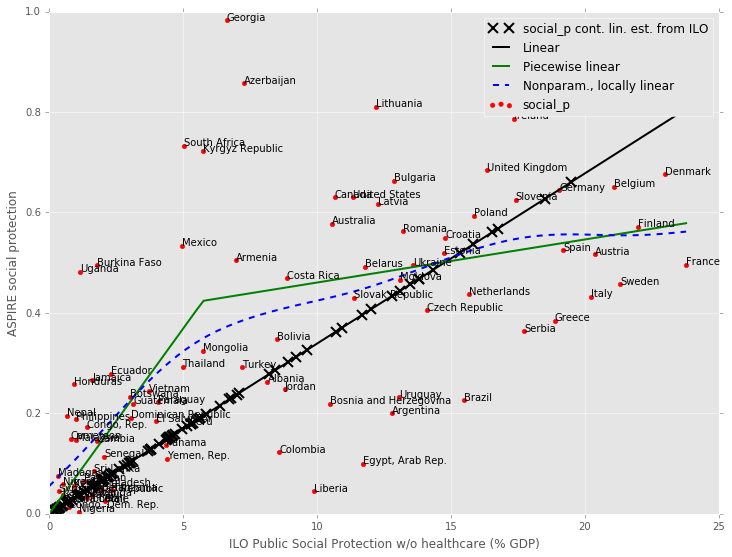

In [148]:
fig1 = plt.figure(figsize=[12,9])
plt.scatter(df_plot['Public social protection (% GDP)'], df_plot['social_p'], color='r', clip_on=False)

for k in df_plot.index.values:
    plt.annotate(xy = [df_plot.loc[k,'Public social protection (% GDP)'], df_plot.loc[k,'social_p']], s=k, xycoords='data')

plt.plot(ILO_data.loc[country_diff]['Public social protection (% GDP)'],
         df_socprot_missing['social_p cont. lin. est. from ILO'], 'kx', mew=2, ms=10)

plt.plot(x_grid, y_hat_lin_p, label="Linear", color = 'k', ls = '-', linewidth=2)
plt.plot(x_grid, y_hat_plin_p, label="Piecewise linear", color = 'g', ls = '-', linewidth=2)
plt.plot(x_grid, k0_p(x_grid), label="Nonparam., locally linear", color = 'blue', ls = '--', linewidth=2)


plt.xlabel('ILO Public Social Protection w/o healthcare (% GDP)')
plt.ylabel('ASPIRE social protection')
plt.xlim(0)
plt.ylim([0,1])
plt.legend()

plt.savefig('output/social_p.pdf', type='pdf')

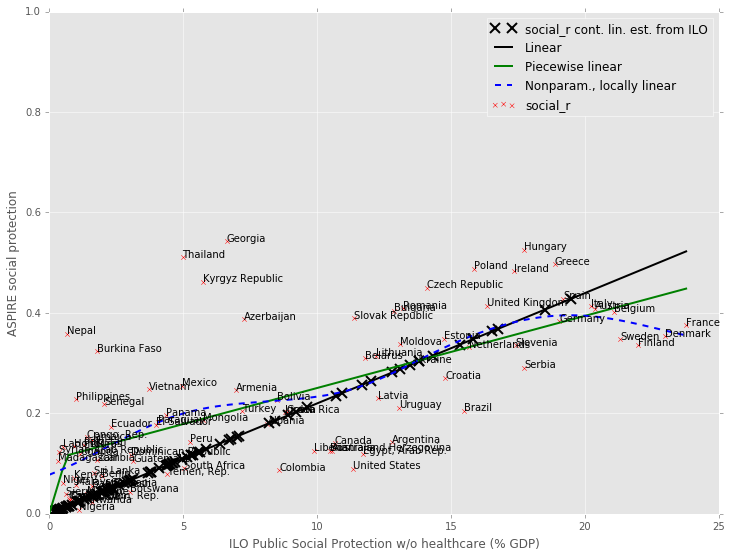

In [149]:
fig1 = plt.figure(figsize=[12,9])
plt.scatter(df_plot['Public social protection (% GDP)'], df_plot['social_r'], color='red', marker='x', clip_on=False)

#for k in df_plot.index:
for k in df_plot.index.values:
    plt.annotate(xy = [df_plot.loc[k,'Public social protection (% GDP)'], df_plot.loc[k,'social_r']], s=k,
                 xycoords='data')

plt.plot(ILO_data.loc[country_diff]['Public social protection (% GDP)'],
         df_socprot_missing['social_r cont. lin. est. from ILO'], 'kx', mew=2, ms=10)
    
plt.plot(x_grid, y_hat_lin_r, label="Linear", color = 'k', ls = '-', linewidth=2)
plt.plot(x_grid, y_hat_plin_r, label="Piecewise linear", color = 'g', ls = '-', linewidth=2)
plt.plot(x_grid, k0_r(x_grid), label="Nonparam., locally linear", color = 'blue', ls = '--', linewidth=2)


plt.xlabel('ILO Public Social Protection w/o healthcare (% GDP)')
plt.ylabel('ASPIRE social protection')
plt.xlim(0)
plt.ylim([0,1])
plt.legend()

plt.savefig('output/social_r.pdf', type='pdf')

In [150]:
#%matplotlib qt